In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import shap

In [239]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [240]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [241]:
(df_train.isnull().sum()/len(df_train)*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [242]:
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown')
df_train['Embarked'] = df_train['Embarked'].fillna('Unknown')

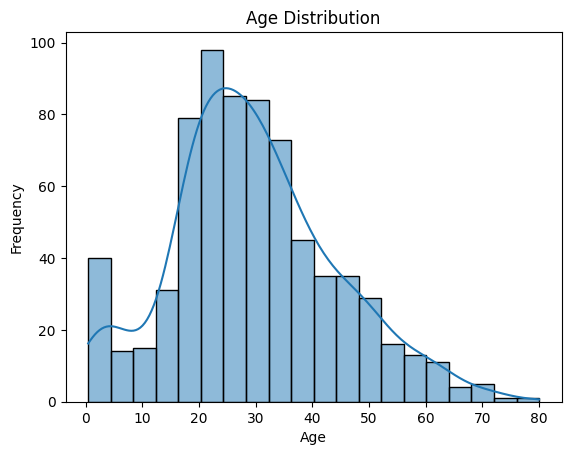

In [243]:
sns.histplot(df_train['Age'].dropna(), kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [244]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())

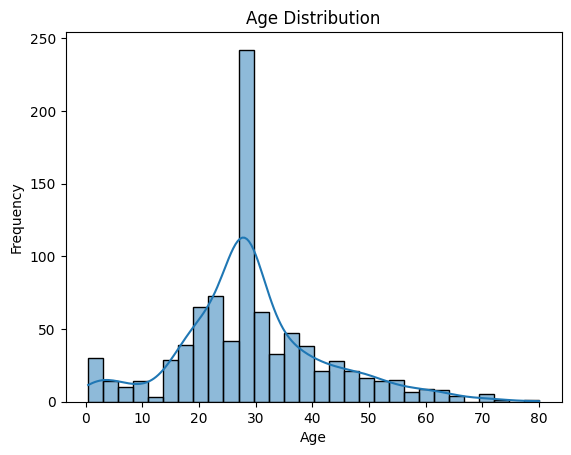

In [245]:
sns.histplot(df_train['Age'].dropna(), kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Survived
0    0.616162
1    0.383838
Name: count, dtype: float64


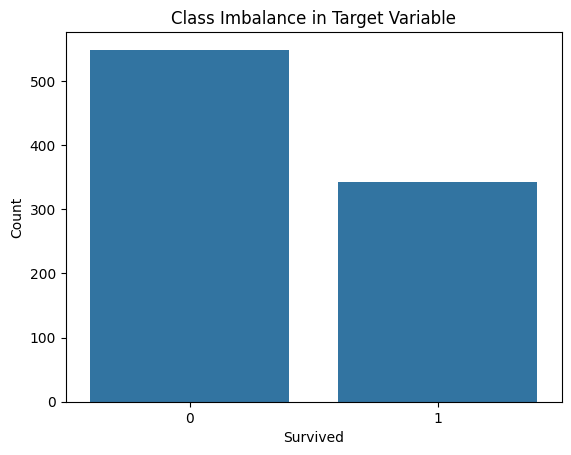

In [246]:
print(df_train['Survived'].value_counts()/len(df_train))

sns.countplot(x = 'Survived', data = df_train)
plt.title('Class Imbalance in Target Variable')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

In [247]:
categorical_features = ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']
numerical_features = ['Age', 'Fare']

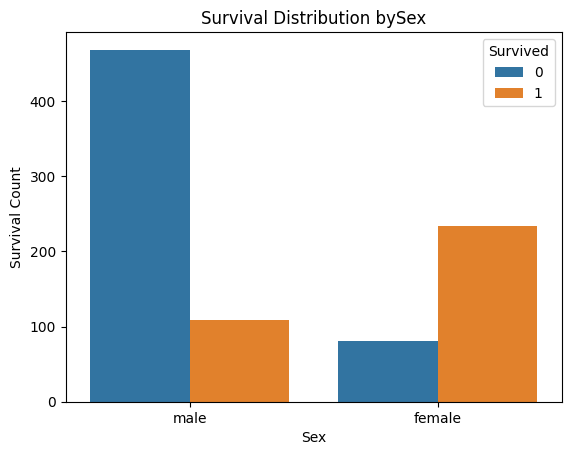

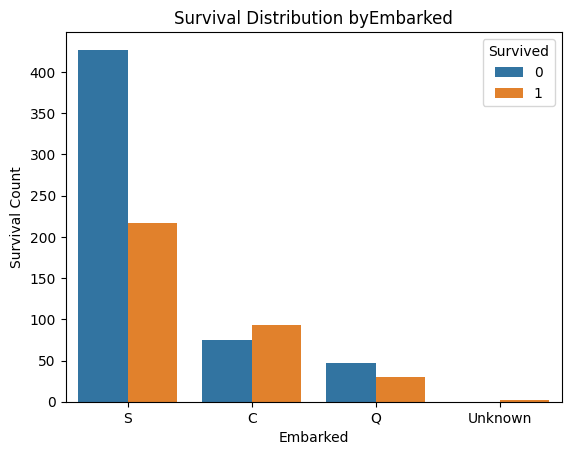

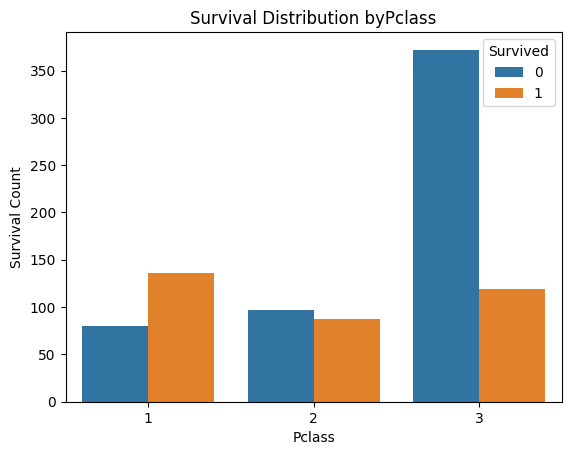

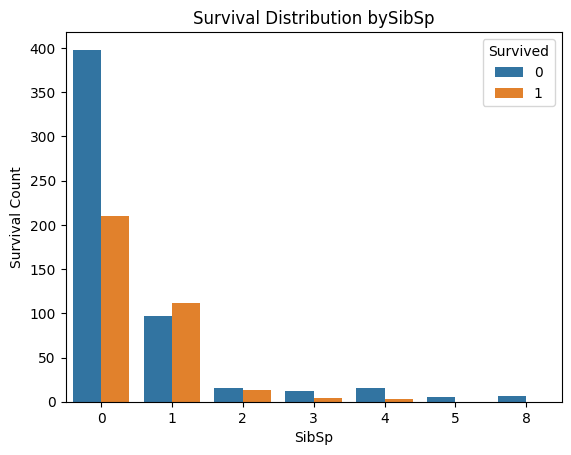

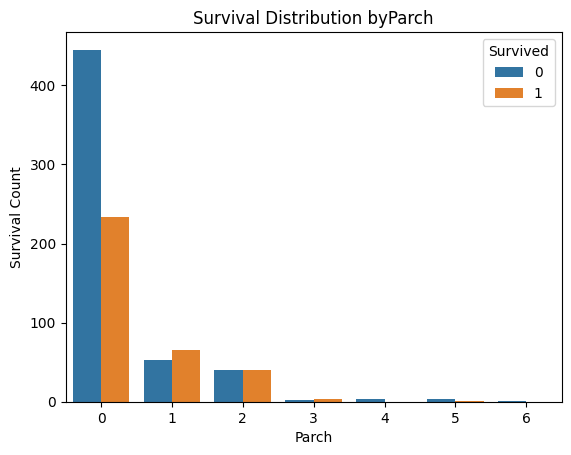

In [248]:
for feature in categorical_features:
    sns.countplot(x = feature, hue = 'Survived', data = df_train)
    plt.title('Survival Distribution by' + feature)
    plt.xlabel(feature)
    plt.ylabel('Survival Count')
    plt.show() 

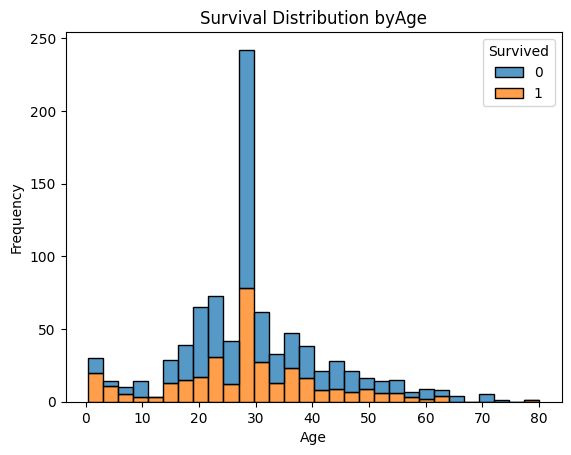

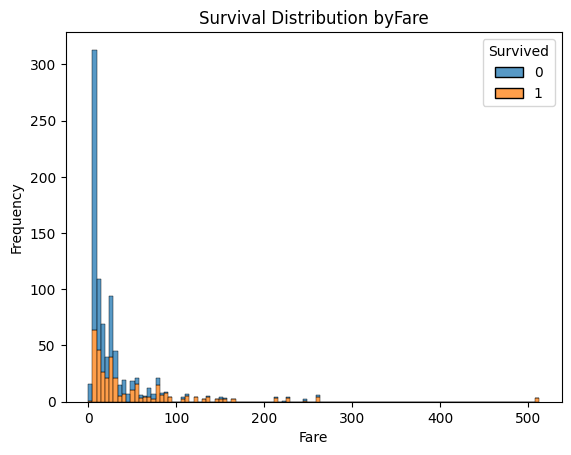

In [249]:
'''
Fare doesn't give us anything concrete. 
'''

for feature in numerical_features:
    sns.histplot(x = df_train[feature].dropna(), hue = 'Survived',multiple = "stack", data = df_train)
    plt.title('Survival Distribution by' + feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show() 

In [250]:
df_train['fare_bins'] = pd.qcut(df_train['Fare'], 4, labels = ['Low', 'Medium', 'High', 'Very High'])
df_train['age_bins'] = pd.cut(df_train['Age'], bins = [0, 12, 20, 40, 60, 80], labels = ['Child', 'Teenager', 'Adult', 'Middle Aged', 'Senior'])

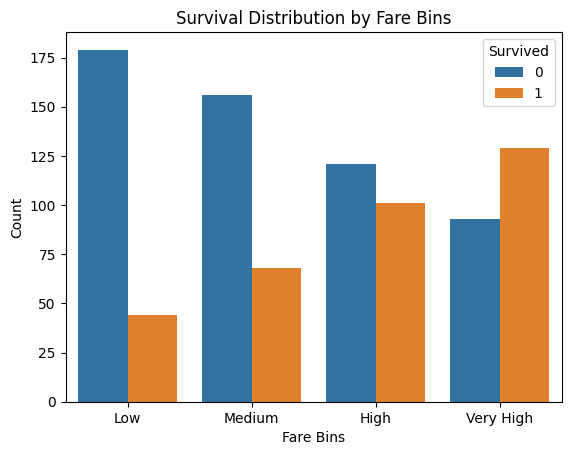

In [251]:
sns.countplot(x = 'fare_bins', hue = 'Survived', data = df_train)
plt.title('Survival Distribution by Fare Bins')
plt.xlabel('Fare Bins')
plt.ylabel('Count')
plt.show()

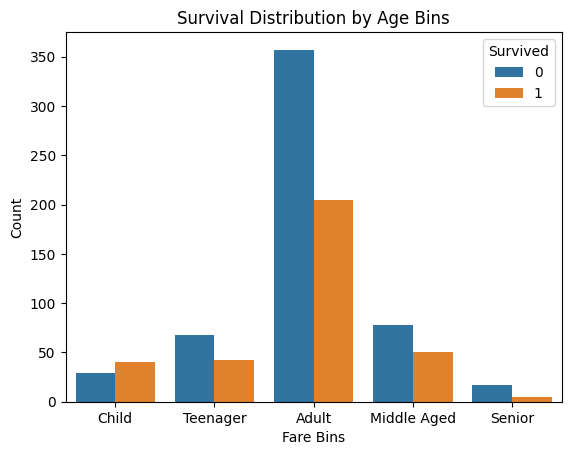

In [252]:
sns.countplot(x = 'age_bins', hue = 'Survived', data = df_train)
plt.title('Survival Distribution by Age Bins')
plt.xlabel('Fare Bins')
plt.ylabel('Count')
plt.show()

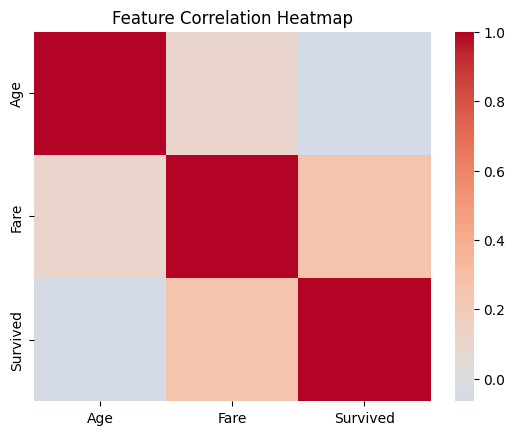

In [253]:
# Correlation between numeric features

corr = df_train[list(numerical_features) + ['Survived']].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [254]:
# Interactions between features
# Fare and age, fare and gender, gender and age

df_train['fare_age_inter'] = df_train['fare_bins'].astype(str) + '_' + df_train['age_bins'].astype(str)
df_train['fare_sex_inter'] = df_train['fare_bins'].astype(str) + '_' + df_train['Sex'].astype(str)
df_train['sex_age_inter'] = df_train['Sex'].astype(str) + '_' + df_train['age_bins'].astype(str)


In [255]:
# Creating the same features in test set

df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

df_test['fare_bins'] = pd.qcut(df_test['Fare'], 4, labels = ['Low', 'Medium', 'High', 'Very High'])
df_test['age_bins'] = pd.cut(df_test['Age'], bins = [0, 12, 20, 40, 60, 80], labels = ['Child', 'Teenager', 'Adult', 'Middle Aged', 'Senior'])
df_test['fare_age_inter'] = df_test['fare_bins'].astype(str) + '_' + df_test['age_bins'].astype(str)
df_test['fare_sex_inter'] = df_test['fare_bins'].astype(str) + '_' + df_test['Sex'].astype(str)
df_test['sex_age_inter'] = df_test['Sex'].astype(str) + '_' + df_test['age_bins'].astype(str)

In [256]:
predictive_features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                       'fare_bins', 'age_bins', 'fare_age_inter', 'fare_sex_inter', 'sex_age_inter']

backup_df = df_train.copy()
df_train = df_train[predictive_features]
df_test = df_test[predictive_features[1:]]


In [257]:
# Encoding Categorical variables

fare_age_hier_map = {
    'Very High_Senior': 0,
    'Very High_Middle Aged': 1,
    'Very High_Adult': 2,
    'Very High_Teenager': 3,
    'Very High_Child': 4,
    'High_Senior': 5,
    'High_Middle Aged': 6,
    'High_Adult': 7,
    'High_Teenager': 8,
    'High_Child': 9,
    'Medium_Senior': 10,
    'Medium_Middle Aged': 11,
    'Medium_Adult': 12,
    'Medium_Teenager': 13,
    'Medium_Child': 14,
    'Low_Senior': 15,
    'Low_Middle Aged': 16,
    'Low_Adult': 17,
    'Low_Teenager': 18,
    'Low_Child': 19
}

fare_sex_hier_map = {
    'Very High_female': 0,
    'Very High_male': 1,
    'High_female': 2,
    'High_male': 3,
    'Medium_female': 4,
    'Medium_male': 5,
    'Low_female': 6,
    'Low_male': 7
}


sex_age_hier_map = {
    'female_Senior': 0,
    'male_Senior': 1,
    'female_Middle Aged': 2,
    'male_Middle Aged': 3,
    'female_Adult': 4,
    'male_Adult': 5,
    'female_Teenager': 6,
    'male_Teenager': 7,
    'female_Child': 8,
    'male_Child': 9
}

# Mapping values on ordinal bins

class_map = {1: 0, 2: 1, 3: 2}
embark_map = {'Q': 0, 'C': 1, 'S': 2}
fare_map = {'Low': 3, 'Medium': 2, 'High': 1, 'Very High': 0}
age_map = {'Child': 4, 'Teenager': 3, 'Adult': 2, 'Middle Aged': 1, 'Senior': 0}
gender_map = {'Female': 0, 'Male': 1}


for x in [df_train, df_test]:
    x['Pclass']          = x['Pclass'].astype('object').map(class_map).fillna(-1).astype('int8')
    x['Embarked']        = x['Embarked'].astype('object').map(embark_map).fillna(-1).astype('int8')
    x['Sex']             = x['Sex'].astype('object').map(gender_map).fillna(-1).astype('int8')
    x['age_bins']        = x['age_bins'].astype('object').map(age_map).fillna(-1).astype('int8')
    x['fare_bins']       = x['fare_bins'].astype('object').map(fare_map).fillna(-1).astype('int8')
    x['fare_age_inter']  = x['fare_age_inter'].astype('object').map(fare_age_hier_map).fillna(-1).astype('int8')
    x['fare_sex_inter']  = x['fare_sex_inter'].astype('object').map(fare_sex_hier_map).fillna(-1).astype('int8')
    x['sex_age_inter']   = x['sex_age_inter'].astype('object').map(sex_age_hier_map).fillna(-1).astype('int8')


In [258]:
# One Hot Encoding for nominal features

ord_features = ['Sex', 'SibSp', 'Parch']

X = df_train.drop(columns=['Survived'])
y = df_train['Survived']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ct = ColumnTransformer(transformers=[('onehot', ohe, ord_features)], remainder='passthrough')

X_encoded = ct.fit_transform(X)
test_encoded = ct.transform(df_test)

ohe_features = ct.named_transformers_['onehot'].get_feature_names_out(ord_features)
remaining_features = [col for col in X.columns if col not in ord_features]
all_features = list(ohe_features) + remaining_features

X_encoded = pd.DataFrame(X_encoded, columns=all_features, index=X.index)
test_encoded = pd.DataFrame(test_encoded, columns=all_features, index=df_test.index)

X_encoded.head()

,Sex_-1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,...,Parch_6,Pclass,Age,Fare,Embarked,fare_bins,age_bins,fare_age_inter,fare_sex_inter,sex_age_inter
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,22.0,7.2500,2.0,3.0,2.0,17.0,7.0,5.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,38.0,71.2833,1.0,0.0,2.0,2.0,0.0,4.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,26.0,7.9250,2.0,2.0,2.0,12.0,4.0,4.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,35.0,53.1000,2.0,0.0,2.0,2.0,0.0,4.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,35.0,8.0500,2.0,2.0,2.0,12.0,5.0,5.0


In [261]:
# Split Training data for evaluation

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (712, 24)
Validation set: (179, 24)


In [ ]:
# Run a grid search to find best hyperparameters for each model

# XGBoost RandomizedSearchCV
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 1.5, 2]
}
xgb_search = RandomizedSearchCV(
    XGBClassifier(objective="binary:logistic", eval_metric="aucpr", random_state=10, n_jobs=-1),
    xgb_param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=10,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)

# RandomForest RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=10, n_jobs=-1),
    rf_param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=10,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

# LogisticRegression RandomizedSearchCV
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [200, 500, 1000]
}
lr_search = RandomizedSearchCV(
    LogisticRegression(random_state=10),
    lr_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=10,
    n_jobs=-1
)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best LR params:", lr_search.best_params_)

# Use best models in ensemble
ensemble = VotingClassifier(
    estimators=[('xgb', best_xgb), ('rf', best_rf), ('lr', best_lr)],
    voting='soft'
)
ensemble.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params: {'subsample': 0.6, 'scale_pos_weight': 1.5, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    valida

Best RF params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Usama\AppData\Roaming\Python\Python312\site-p

Best LR params: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 1}


C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='aucpr',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_const...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=400,
                                                     n_jobs=-1,
                                                     random_state=10)),
                             ('lr',
                              LogisticRegression(C=1, max_iter=200,
                                                 random_state=10))],
                 voting='soft')

In [264]:
# Evaluate
y_val_pred = ensemble.predict(X_val)
y_val_pred_proba = ensemble.predict_proba(X_val)[:, 1]
print("Ensemble Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Ensemble Validation ROC-AUC:", roc_auc_score(y_val, y_val_pred_proba))

Ensemble Validation Accuracy: 0.8379888268156425
Ensemble Validation ROC-AUC: 0.8498023715415021


In [ ]:

# Predict on test set

ensemble.fit(X_encoded, y)
test_predictions = ensemble.predict(test_encoded)
test_probabilities = ensemble.predict_proba(test_encoded)[:, 1]
results_df = df_test.copy()
results_df['predicted_survival'] = test_predictions
results_df['survival_probability'] = test_probabilities
results_df.to_csv('titanic_test_predictions_ensemble.csv', index=False)


Results saved to 'titanic_test_predictions_ensemble.csv'
